In [1]:
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI')
import torch
import numpy as np
import torchvision
from matplotlib import pyplot as plt
torch.manual_seed(0)
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
from BasicExample.src.LLVI_network import LLVI_network_diagonal, LLVI_network_KFac, Log_likelihood_type
from BasicExample.src.basic_CNN import Net, NonBayesianNet

In [13]:
batch_size_train = 32
batch_size_test = 1000
filepath = "/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI/BasicExample/files"
download = False
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(filepath, train=True, download=download,
                            transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ])),
  batch_size=batch_size_train, shuffle=True)
n_datapoints = batch_size_train * len(train_loader)

test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(filepath, train=False, download=download,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ])),
batch_size=batch_size_test, shuffle=True)

ood_test_loader = torch.utils.data.DataLoader(
torchvision.datasets.FashionMNIST(filepath, train=False, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))#,
                                # torchvision.transforms.RandomHorizontalFlip(p=1)
                            ])),
batch_size=batch_size_test, shuffle=True)

# ood_test_loader = torch.utils.data.DataLoader(
# torchvision.datasets.MNIST(filepath, train=False, download=True,
#                             transform=torchvision.transforms.Compose([
#                                 torchvision.transforms.ToTensor(),
#                                 torchvision.transforms.Normalize((0.1307,), (0.3081,)),
#                                 torchvision.transforms.RandomHorizontalFlip(p=1)
#                             ])),
# batch_size=batch_size_test, shuffle=True)

In [3]:
raw_minst = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(filepath, train=False, download=download,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ])),
batch_size=5000, shuffle=True)

In [4]:
def test_confidence(model, test_loader, ood_test_loader, foward_pass_function):
    model.eval()
    confidence_batch = torch.zeros(len(test_loader))
    accuracy_batch = torch.zeros(len(test_loader))
    with torch.no_grad():
        for index, (data, target) in enumerate(test_loader):
            output_probs = foward_pass_function(data)
            pred, class_pred = torch.max(output_probs, dim=1) # confidence in choice
            confidence_batch[index] = torch.mean(pred)
            accuracy = (class_pred == target).float().mean()
            accuracy_batch[index] = accuracy
        print(f"The mean confidence for in distribution data is: {sum(confidence_batch)/len(confidence_batch)}")
        print("Mean accuracy:", torch.mean(accuracy_batch).item())

    ood_confidence_batch = torch.zeros(len(ood_test_loader))
    ood_accuracy_batch = torch.zeros(len(test_loader))
    with torch.no_grad():
        for index, (data, target) in enumerate(ood_test_loader):
            output_probs= foward_pass_function(data)
            pred, class_pred = torch.max(output_probs, dim=1) # confidence in choice
            ood_confidence_batch[index] = torch.mean(pred)
            accuracy = (class_pred == target).float().mean()
            ood_accuracy_batch[index] = accuracy
        print(f"The mean confidence for out-of distribution data is: {sum(ood_confidence_batch)/len(ood_confidence_batch)}")
        print("Mean ood accuracy:", torch.mean(ood_accuracy_batch).item())

In [5]:
def calculate_calibration(model, test_loader, bin_size, predict_fun):
    model.eval()
    n_bins = int(1/bin_size)
    # bins = torch.linspace(bin_size, 1, n_bins)
    # bin_predictions = [None] * 10
    bin_calibration = [[] for _ in range(n_bins)]
    with torch.no_grad():
        for index, (data, target) in enumerate(test_loader):
            output_probs = predict_fun(data)
            pred_conf, class_pred = torch.max(output_probs, dim=1) # confidence in choice
            for bin_index in range(1, n_bins+1):
                pred_index = (pred_conf <(bin_index * bin_size)).nonzero(as_tuple=True)[0]
                bin_pred = class_pred[pred_index]
                bin_target = target[pred_index]
                bin_calibration[bin_index-1] += list(bin_pred == bin_target)

    returnvalue = []
    for i in range(n_bins):
        if len(bin_calibration[i]) > 0:
            returnvalue.append(sum(bin_calibration[i])/len(bin_calibration[i]))
        else:
            returnvalue.append(0)

    return torch.linspace(bin_size, 1, n_bins), returnvalue

            


In [6]:
def visualize_calibration(model, data_loader, predict_fun, ax, bin_size=0.1):
    ax.set_title(model.model_config["kernel_name"])
    x, calibration = calculate_calibration(model, data_loader, predict_fun=predict_fun, bin_size=bin_size)
    ax.bar(x, calibration, width=bin_size*0.9)
    ax.axline((0,0), (1,1), color="red")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks(x)
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")
    

## Baseline

In [7]:
non_bayes_net = NonBayesianNet()
# non_bayes_net.train_model(train_loader, epochs=40);
non_bayes_net.load_state_dict(torch.load("/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI/BasicExample/files/models/MNIST/Baseline/epoch_40.pt"))
non_bayes_net.model_config = {"kernel_name": "Baseline"}

In [14]:
test_confidence(non_bayes_net, test_loader, ood_test_loader, non_bayes_net.predict)

The mean confidence for in distribution data is: 0.9930667877197266
Mean accuracy: 0.9919000864028931
The mean confidence for out-of distribution data is: 0.5066167712211609
Mean ood accuracy: 0.11729999631643295


In [9]:
# torch.save(non_bayes_net.state_dict(), "/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI/BasicExample/files/models/MNIST/Baseline/epoch_40.pt")

## Diagonal

In [10]:
# test the diagonal gaussian net
feature_extractor_net = Net()
Diag_net = LLVI_network_diagonal(feature_extractor=feature_extractor_net,
    feature_dim=50, out_dim= 10,
    prior_mu=0, prior_log_var=-3,
    init_ll_mu=0,init_ll_log_var=0,
    lr=5e-3, tau=1, bias=False, loss=Log_likelihood_type.CATEGORICAL, data_log_var=None)

Diag_net.train_model(train_loader, len(train_loader) * batch_size_train, epochs=20, samples=5, train_hyper=True);
# Diag_net.load("/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI/BasicExample/files/models/MNIST/Diagonal/10-11-2021_17-42-55")

Loss:0.44, Data LogLik:0.29, KL Loss:0.15: 100%|██████████| 20/20 [09:14<00:00, 27.72s/it]


In [15]:
test_confidence(Diag_net, test_loader, ood_test_loader, Diag_net.predict_softmax_classification)

The mean confidence for in distribution data is: 0.9787785410881042
Mean accuracy: 0.9852999448776245
The mean confidence for out-of distribution data is: 0.24645361304283142
Mean ood accuracy: 0.09480001032352448


In [16]:
# Diag_net.save("/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI/BasicExample/files/models/MNIST/Diagonal")

'/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI/BasicExample/files/models/MNIST/Diagonal/11-11-2021_10-36-47'

## Full Covariance

In [12]:
feature_extractor_full_cov = Net()
full_cov_model = LLVI_network_KFac(feature_extractor=feature_extractor_full_cov,
feature_dim=50, out_dim=10,
A_dim = 50, B_dim=10,
prior_mu=0, prior_log_var=-3,
init_ll_mu=0, init_ll_cov_scaling=0.5,
tau=0.1, lr=5e-3,  bias=False, loss=Log_likelihood_type.CATEGORICAL, data_log_var=None)

full_cov_model.train_model(train_loader, n_datapoints=len(train_loader) * batch_size_train, epochs=20, samples=5, train_hyper=True, update_freq=5)

Loss:2.35, Data LogLik:2.3, KL Loss:0.04:  20%|██        | 4/20 [03:51<15:26, 57.89s/it]


KeyboardInterrupt: 

## Evaluation

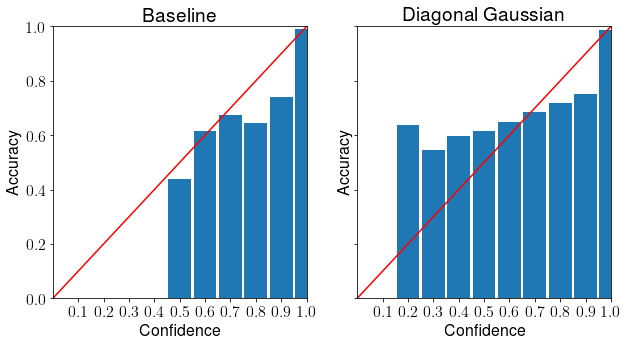

In [12]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
axs_flat = axs.flat
visualize_calibration(non_bayes_net, raw_minst, non_bayes_net.predict, next(axs_flat))
visualize_calibration(Diag_net, raw_minst, Diag_net.predict_softmax_classification, next(axs_flat))
# fig.savefig("/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI/presentations/shortpresentation_13_11/images/MNIST/calibration.jpg")